In [ ]:
!pip install pillow
!pip install split-folders

import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import SGD

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 23 22:09:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget http://drive.genos-drive.workers.dev/allimages.zip
!wget http://drive.genos-drive.workers.dev/allimages.txt
!wget http://drive.genos-drive.workers.dev/labels.txt
!mkdir cars
!unzip allimages.zip -d /content/cars

splitfolders.ratio('cars', output="output", ratio=(.8, 0.1,0.1)) 

Streaming output truncated to the last 5000 lines.
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11325.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11356.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11347.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11313.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11320.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11339.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11298.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11329.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11342.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11351.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11340.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11354.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11299.jpg  
  inflating: /content/cars/Hyundai Sonata Sedan 2012/11345.jpg  
  inflating: /content/cars/Hyundai Sona

Copying files: 16185 files [00:03, 4465.29 files/s]


In [ ]:
#Parameters
batch_size = 32
size=(224, 224)
num_classes = 196
input_tensor = Input(shape=(224, 224, 3))

In [ ]:
data_augmentation = keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)
    ]
)

def load_dataset(dir):
  return keras.preprocessing.image_dataset_from_directory(
        dir,  
        image_size=size, 
        batch_size=batch_size,
        labels="inferred",
        seed=1337,
        label_mode="categorical",
        color_mode="rgb",
        shuffle=True) 
  
def data_aug(generator,data_augmentation,train):
  generator=generator.map(lambda x, y: (data_augmentation(x, training=train), y))
  return generator.prefetch(buffer_size=batch_size)



In [ ]:
train_generator = load_dataset('/content/output/train')
validation_generator = load_dataset('/content/output/val')
test_generator = load_dataset('/content/output/test')


train_generator = data_aug(train_generator,data_augmentation,True)
validation_generator = data_aug(validation_generator,data_augmentation,False)
test_generator = data_aug(test_generator,data_augmentation,False)


Found 12873 files belonging to 196 classes.
Found 1524 files belonging to 196 classes.
Found 1788 files belonging to 196 classes.


In [ ]:
base_model = tf.keras.applications.ResNet152V2(input_tensor=input_tensor,include_top=False)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='categorical_crossentropy',metrics=[tf.keras.metrics.CategoricalAccuracy()])

234553344/234545216 [==============================] - 4s 0us/step


In [ ]:
his=model.fit(train_generator,
    validation_data=validation_generator,
    epochs=30)

Epoch 1/30
403/403 [==============================] - 188s 394ms/step - loss: 4.4295 - categorical_accuracy: 0.1008 - val_loss: 3.2264 - val_categorical_accuracy: 0.2900
Epoch 2/30
403/403 [==============================] - 157s 387ms/step - loss: 1.7396 - categorical_accuracy: 0.5266 - val_loss: 2.1647 - val_categorical_accuracy: 0.4606
Epoch 3/30
403/403 [==============================] - 156s 386ms/step - loss: 0.8396 - categorical_accuracy: 0.7603 - val_loss: 1.3359 - val_categorical_accuracy: 0.6358
Epoch 4/30
403/403 [==============================] - 156s 386ms/step - loss: 0.4357 - categorical_accuracy: 0.8672 - val_loss: 1.1552 - val_categorical_accuracy: 0.6975
Epoch 5/30
403/403 [==============================] - 156s 386ms/step - loss: 0.2825 - categorical_accuracy: 0.9175 - val_loss: 1.1195 - val_categorical_accuracy: 0.7146
Epoch 6/30
403/403 [==============================] - 156s 386ms/step - loss: 0.1702 - categorical_accuracy: 0.9500 - val_loss: 0.7901 - val_categoric

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)


Evaluate on test data
56/56 [==============================] - 8s 131ms/step - loss: 0.5631 - categorical_accuracy: 0.8708
test loss, test acc: [0.5630573630332947, 0.8708053827285767]


In [ ]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


In [ ]:
!zip -r my_model.zip my_model/

  adding: my_model/ (stored 0%)
  adding: my_model/variables/ (stored 0%)
  adding: my_model/variables/variables.index (deflated 84%)
  adding: my_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: my_model/saved_model.pb (deflated 94%)
  adding: my_model/assets/ (stored 0%)


In [ ]:
!cp my_model.zip "/content/drive/MyDrive/my_model_resnet152v2.zip"

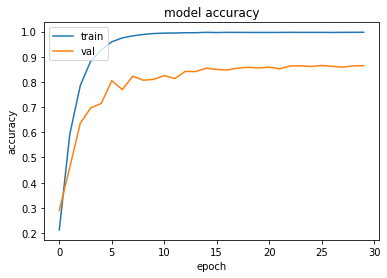

In [ ]:
from matplotlib import pyplot as plt
plt.plot(his.history['categorical_accuracy'])
plt.plot(his.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

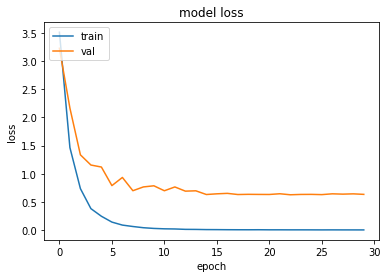

In [ ]:
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()